In [2]:
    import fiona
    import os,os.path
    from shapely.geometry import shape,mapping
    from shapely.ops import transform
    from functools import partial
    import pyproj
    from fiona.crs import from_epsg
    import osmnx as ox
    import matplotlib.pyplot as plt
    import geopandas as gpd
    import glob
    import json
    import numpy as np
    import requests as rq
    import collections
    import logging
    import time
    from PIL import Image
    from io import BytesIO
    import pandas as pd
    import dateutil.parser
    from tqdm import tqdm
    import seaborn as sns
    %matplotlib inline

In [3]:
map_images = pd.read_csv('scratchpad/Mappilary_image_data_df_V3.csv')
map_features = pd.read_csv('scratchpad/Mapillary_20city_urban_features_Final.csv')

In [4]:
map_images['year'] = map_images['captureTime'].apply(lambda x: x.split('-')[0].strip())

In [5]:
map_images.head()

,Unnamed: 0,Imgkey,long,lat,isPano,captureTime,long_lat_string,city,year
0,0,LvAH_MniU5aoQcqGUSaRfg,24.929696,60.164457,False,2017-05-06T17:08:05.000Z,24.9297_60.1645,Helsinki,2017
1,1,I-UrvuxcsFzyOixxzKftXA,24.929745,60.164460,False,2016-12-13T08:30:47.671Z,24.9297_60.1645,Helsinki,2016
2,2,PLLDa2_eRgQMp3kciCYzEA,24.929622,60.164430,False,2017-05-06T17:08:04.000Z,24.9296_60.1644,Helsinki,2017
3,3,w35tfBtc8gOlIG3TK52Kag,24.929707,60.164380,False,2019-07-11T06:42:15.876Z,24.9297_60.1644,Helsinki,2019
4,4,3zWRV2aQtC1XES3hSyNtip,24.929800,60.164474,False,2020-08-13T18:23:35.000Z,24.9298_60.1645,Helsinki,2020


In [6]:
map_features.head(n=2)

,Unnamed: 0,ImgId,ObjEntropy,SceneEntropy,__background__,person,bicycle,car_coco,motorcycle,airplane,...,terrain,sky,person_enet,rider_enet,car_enet,truck_enet,bus_enet,train_enet,motorcycle_enet,bicycle_enet
0,0,pPbGnlvoqb88c9oYn068VH,0.049570,1.893505,0,0,0,1,0,0,...,0.018312,0.011059,0.006845,0.000417,0.162331,0.024518,0.018472,0.009128,0.004870,0.016957
1,1,uDQnOWWRqR0e3e9Gdca5lw,0.521312,1.799529,0,2,5,13,0,0,...,0.004219,0.005264,0.124756,0.008413,0.058877,0.047642,0.000078,0.001445,0.004077,0.063989


In [7]:
city_images = []
city_name = []
city_years = {}
for name , group in map_images.groupby('city'):
    city_images.append(len(set(group['long_lat_string'])))
    city_name.append(name)

In [8]:
year_images = []
year  = []
for name , group in map_images.groupby('year'):
    year_images.append(len(group))
    year.append(name)

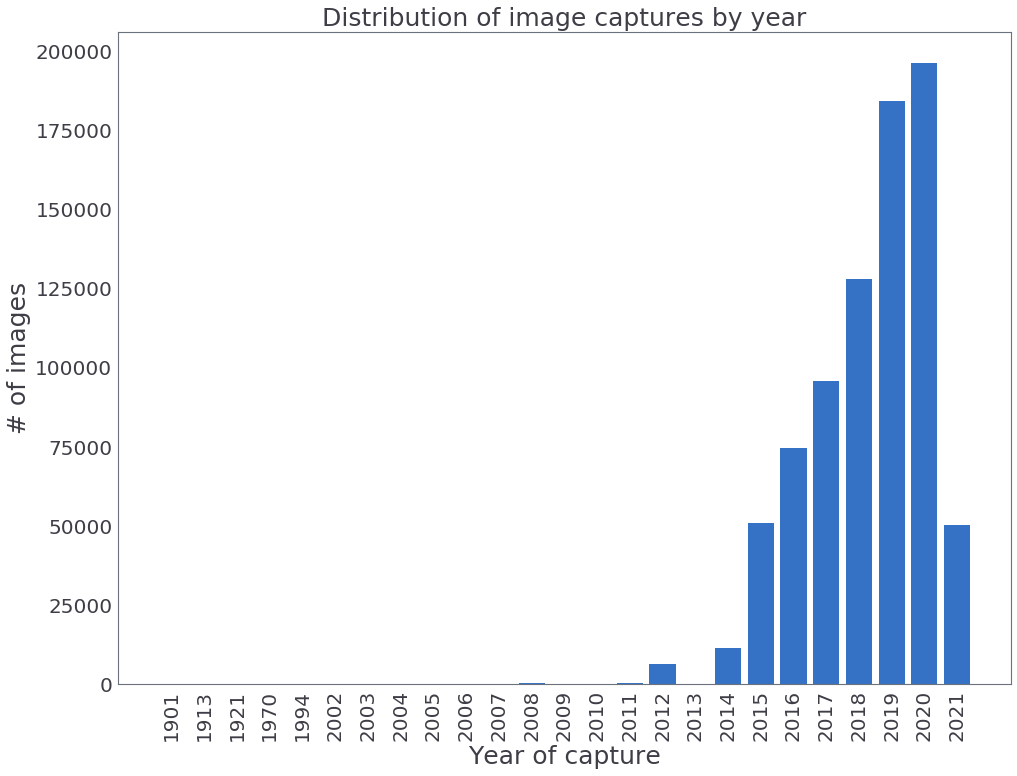

In [9]:
x = np.arange(len(year))
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
plt.grid()
plt.bar(x, year_images)
plt.title('Distribution of image captures by year',fontsize=25)
plt.yticks(fontsize=20)
plt.ylabel('# of images',fontsize=25)
plt.xticks(x, year ,rotation=90,fontsize=20)
plt.xlabel('Year of capture',fontsize=25)
plt.show()

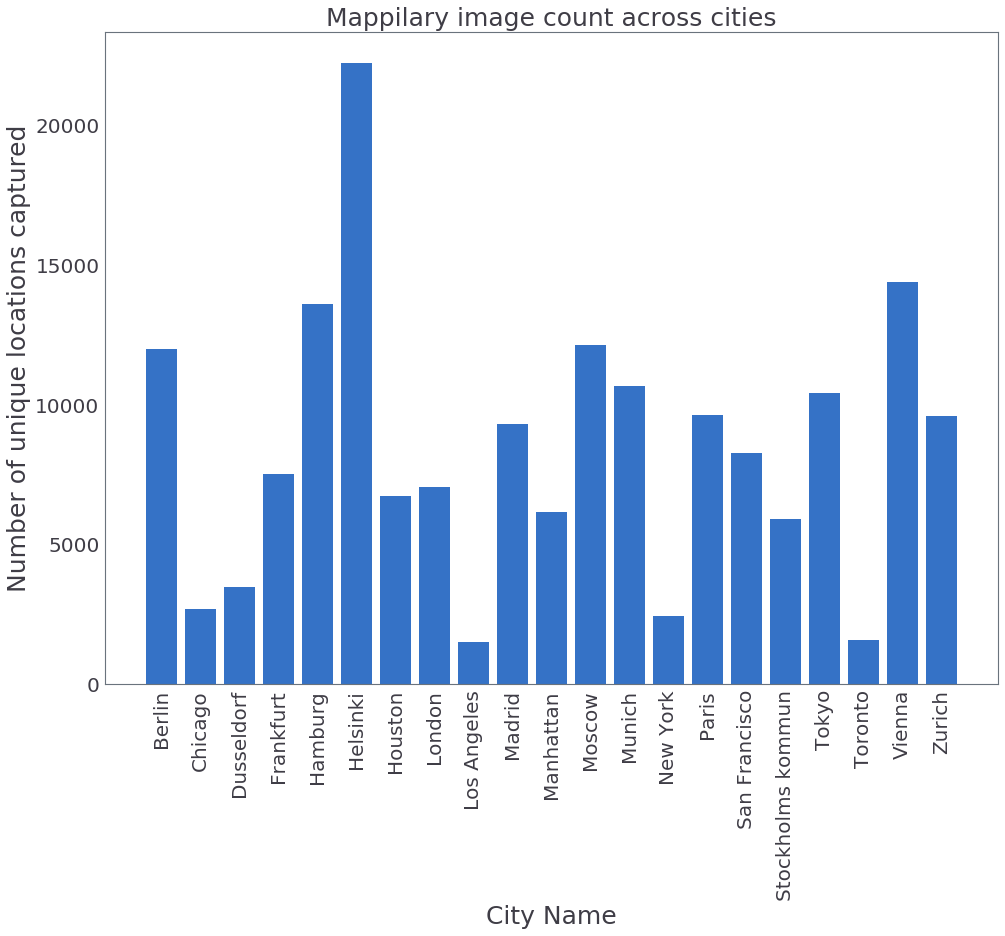

In [10]:
x = np.arange(len(city_name))
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
plt.grid()
plt.bar(x, city_images)
plt.title('Mappilary image count across cities',fontsize=25)
plt.yticks(fontsize=20)
plt.ylabel('Number of unique locations captured',fontsize=25)
plt.xticks(x, city_name ,rotation=90,fontsize=20)
plt.xlabel('City Name',fontsize=25)
plt.show()

In [11]:
total_mappilary_df = pd.merge(map_images,map_features,left_on='Imgkey',right_on='ImgId')

In [12]:
def Entropy(array):
    classProb = [k/(sum(array)+1) for k in array]
    entropy = - sum([classProb[i]*np.log(classProb[i]) for i in range(len(classProb)) if classProb[i] > 0 ])
    return entropy

def Entropy_new(array):
    entropy = - sum([array[i]*np.log(array[i]) for i in range(len(array)) if array[i] > 0 ])
    return entropy

In [13]:
len(total_mappilary_df)

798244

In [14]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car_coco', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant',  'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator',  'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

countDict = {}
for k in COCO_INSTANCE_CATEGORY_NAMES:
    countDict[k] = sum(total_mappilary_df[k])

In [15]:
dict(sorted(countDict.items(), key=lambda item: item[1]))

{'__background__': 0,
 'sandwich': 2,
 'hot dog': 3,
 'toaster': 3,
 'pizza': 21,
 'hair drier': 24,
 'zebra': 31,
 'carrot': 36,
 'orange': 38,
 'apple': 68,
 'giraffe': 69,
 'banana': 79,
 'bear': 85,
 'donut': 85,
 'scissors': 105,
 'fork': 129,
 'cake': 138,
 'spoon': 141,
 'broccoli': 168,
 'toothbrush': 257,
 'baseball glove': 263,
 'toilet': 263,
 'sheep': 264,
 'snowboard': 284,
 'oven': 290,
 'wine glass': 292,
 'microwave': 311,
 'baseball bat': 312,
 'teddy bear': 349,
 'cat': 411,
 'knife': 422,
 'bed': 466,
 'couch': 487,
 'tennis racket': 495,
 'tie': 499,
 'skis': 507,
 'keyboard': 511,
 'elephant': 662,
 'remote': 667,
 'laptop': 681,
 'bowl': 958,
 'frisbee': 982,
 'surfboard': 1019,
 'sink': 1019,
 'cow': 1618,
 'cell phone': 1733,
 'vase': 1851,
 'airplane': 2060,
 'refrigerator': 2072,
 'kite': 2127,
 'dog': 2836,
 'cup': 3449,
 'dining table': 3481,
 'mouse': 3619,
 'parking meter': 4230,
 'sports ball': 4738,
 'skateboard': 4955,
 'bird': 5577,
 'suitcase': 5886,


In [16]:
segnetDict = {'Car_Infrastructure_enet' : ['road', 'pole_enet', 'traffic_light', 'traffic_sign', 'car_enet', 'truck_enet', 'bus_enet',  'motorcycle_enet'],
              'Pedestrians_enet': ['sidewalk', 'person_enet', 'bicycle_enet'],
              'Architecture_enet' : ['building', 'wall', 'fence_enet'],
              'Nature_enet': ['vegetation', 'terrain', 'sky']
             }



cocoDict = {'Car_Infrastructure_coco' : ['stop sign','boat','motorcycle','bus','truck','traffic light','car_coco'],
'Pedestrians_coco': ['umbrella','backpack','handbag','bicycle','person'],
'Architecture_coco' : ['clock','bench'],
'Nature_coco': ['horse','potted plant']
           }


In [17]:
placesNet_df = pd.read_csv('../Data/Mappilary_city_placesNet.csv')

In [18]:
# placesNet_df['Walkable'] = placesNet_df['Walkable'] - 0.0001
# placesNet_df['Landmark'] = placesNet_df['Landmark'] - 0.0002
# placesNet_df['Architecture'] = placesNet_df['Architecture'] + 0.0001
# placesNet_df['Natural'] = placesNet_df['Natural'] + 0.0002

In [19]:
# placesNet_max =  placesNet_df[['Walkable' , 'Landmark', 'Architecture', 'Natural']].apply(lambda x: x == x.max(), axis=1).astype(int) 

In [20]:
# placesNet_max.head(n=5)

In [21]:
# placesNet_max.sum(axis=0)

In [22]:
# placesNet_max.rename(columns={'Walkable':'W', 'Landmark':'L','Architecture':'A','Natural':'N'},inplace=True)

In [23]:
# placesNet_df = pd.merge(placesNet_df, placesNet_max,left_index=True, right_index=True)

In [24]:
# placesNet_df['places_entropy'] = placesNet_df.apply(lambda x: Entropy_new([x[col] for col in ['Walkable' , 'Landmark', 'Architecture', 'Natural']]) , axis = 1 )

In [25]:
placesNet_df[['Architecture','Landmark','Natural','Walkable']].corr()

,Architecture,Landmark,Natural,Walkable
Architecture,1.000000,-0.238676,-0.186304,-0.475084
Landmark,-0.238676,1.000000,-0.006178,-0.404647
Natural,-0.186304,-0.006178,1.000000,-0.317282
Walkable,-0.475084,-0.404647,-0.317282,1.000000


In [26]:
placesNet_df.head()

,Unnamed: 0,Architecture,Landmark,N/A,Natural,Unnamed: 0.1,Walkable,imgKey,placesNet_labels
0,0,0.0,0.6,0.0,0.0,0.0,0.4,pPbGnlvoqb88c9oYn068VH,"['plaza', 'embassy', 'street', 'subway_station..."
1,1,0.6,0.2,0.0,0.0,1.0,0.2,uDQnOWWRqR0e3e9Gdca5lw,"['residential_neighborhood', 'street', 'apartm..."
2,2,0.2,0.0,0.2,0.0,2.0,0.6,i9CFCOnZErlyETxBfVNgAA,"['street', 'alley', 'downtown', 'residential_n..."
3,3,0.4,0.0,0.2,0.0,3.0,0.4,JI9N8XEtaV7G66K0PFVo_g,"['downtown', 'street', 'crosswalk', 'parking_g..."
4,4,0.4,0.2,0.0,0.0,4.0,0.4,y-0mK7IyYGb-1rW25PikrQ,"['crosswalk', 'highway', 'residential_neighbor..."


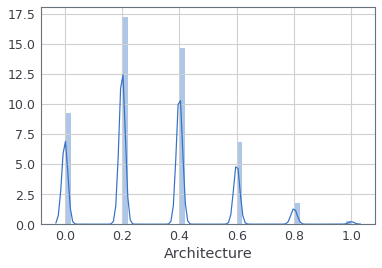

In [27]:
sns.distplot(placesNet_df['Architecture'])

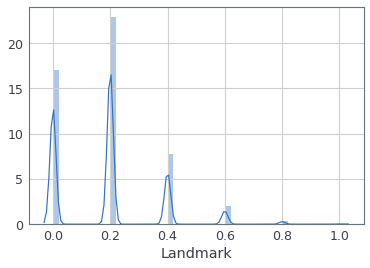

In [28]:
sns.distplot(placesNet_df['Landmark'])

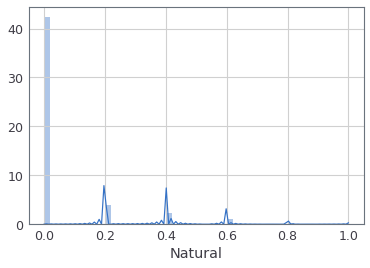

In [29]:
sns.distplot(placesNet_df['Natural'])

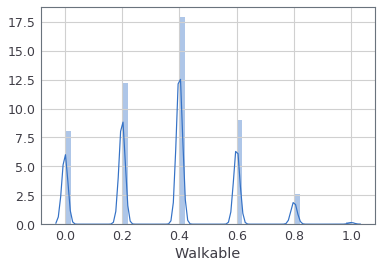

In [30]:
sns.distplot(placesNet_df['Walkable'])

In [31]:
placesNet_df.head()

,Unnamed: 0,Architecture,Landmark,N/A,Natural,Unnamed: 0.1,Walkable,imgKey,placesNet_labels
0,0,0.0,0.6,0.0,0.0,0.0,0.4,pPbGnlvoqb88c9oYn068VH,"['plaza', 'embassy', 'street', 'subway_station..."
1,1,0.6,0.2,0.0,0.0,1.0,0.2,uDQnOWWRqR0e3e9Gdca5lw,"['residential_neighborhood', 'street', 'apartm..."
2,2,0.2,0.0,0.2,0.0,2.0,0.6,i9CFCOnZErlyETxBfVNgAA,"['street', 'alley', 'downtown', 'residential_n..."
3,3,0.4,0.0,0.2,0.0,3.0,0.4,JI9N8XEtaV7G66K0PFVo_g,"['downtown', 'street', 'crosswalk', 'parking_g..."
4,4,0.4,0.2,0.0,0.0,4.0,0.4,y-0mK7IyYGb-1rW25PikrQ,"['crosswalk', 'highway', 'residential_neighbor..."


In [32]:
# placesNet_df_sub = placesNet_df[['imgKey','W','L','A','N']].copy()

In [33]:
total_mappilary_df.describe()

,Unnamed: 0_x,long,lat,Unnamed: 0_y,ObjEntropy,SceneEntropy,__background__,person,bicycle,car_coco,...,terrain,sky,person_enet,rider_enet,car_enet,truck_enet,bus_enet,train_enet,motorcycle_enet,bicycle_enet
count,798244.000000,798244.000000,798244.000000,798244.000000,798244.000000,798244.000000,798244.0,798244.000000,798244.000000,798244.000000,...,798244.000000,798244.000000,798244.000000,798244.000000,798244.000000,798244.000000,798244.000000,798244.000000,798244.000000,798244.000000
mean,399121.500000,12.121823,49.718855,399121.500000,0.238403,1.751076,0.0,1.910507,0.268756,3.860498,...,0.012483,0.060683,0.065664,0.004436,0.075296,0.036935,0.033337,0.069852,0.007402,0.019133
std,230433.338477,57.348128,8.236132,230433.338477,0.139201,0.331809,0.0,3.137059,0.999785,3.897769,...,0.030214,0.086223,0.087846,0.011349,0.095418,0.074203,0.096789,0.164832,0.020554,0.036140
min,0.000000,-122.455821,29.766630,0.000000,0.000000,0.003391,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,199560.750000,8.537794,47.375474,199560.750000,0.133476,1.579446,0.0,0.000000,0.000000,1.000000,...,0.000260,0.000321,0.010234,0.000004,0.014368,0.000395,0.000306,0.000065,0.000004,0.000625
50%,399121.500000,16.364054,51.508659,399121.500000,0.228851,1.789528,0.0,1.000000,0.000000,3.000000,...,0.002135,0.019264,0.031726,0.000518,0.040866,0.005208,0.002365,0.002582,0.000599,0.005667
75%,598682.250000,24.952881,55.743492,598682.250000,0.327557,1.975434,0.0,2.000000,0.000000,6.000000,...,0.010100,0.091832,0.085103,0.003548,0.098926,0.035447,0.014691,0.036331,0.005191,0.021400
max,798243.000000,139.777896,60.179881,798243.000000,1.079616,2.684262,0.0,54.000000,35.000000,35.000000,...,0.878190,0.642409,0.991016,0.383594,0.999102,0.970122,0.994527,0.991172,0.665408,0.810530


In [34]:
total_mappilary_df = pd.merge(total_mappilary_df ,placesNet_df ,left_on='Imgkey',right_on='imgKey')

In [35]:
for k in segnetDict:
    total_mappilary_df[k] = 0.0
    for tag in segnetDict[k]:
        total_mappilary_df[k]+=total_mappilary_df[tag]

In [36]:
for k in cocoDict:
    total_mappilary_df[k] = 0.0
    for tag in cocoDict[k]:
        total_mappilary_df[k]+=total_mappilary_df[tag]

In [37]:
print(list(total_mappilary_df.columns))

['Unnamed: 0_x', 'Imgkey', 'long', 'lat', 'isPano', 'captureTime', 'long_lat_string', 'city', 'year', 'Unnamed: 0_y', 'ImgId', 'ObjEntropy', 'SceneEntropy', '__background__', 'person', 'bicycle', 'car_coco', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', '

In [38]:
total_mappilary_df['segNet_entropy_new'] = total_mappilary_df.apply(lambda x: Entropy([x[col] for col in segnetDict.keys()]) , axis = 1 )

In [39]:
total_mappilary_df['coco_entropy_new'] = total_mappilary_df.apply(lambda x: Entropy([x[col] for col in cocoDict.keys()]) , axis = 1 )

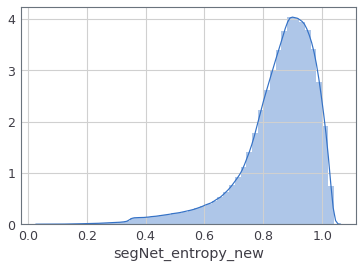

In [40]:
sns.distplot(total_mappilary_df['segNet_entropy_new'])

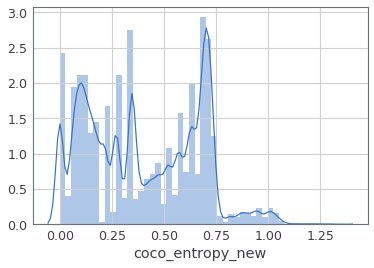

In [41]:
sns.distplot(total_mappilary_df['coco_entropy_new'])

In [42]:
city_road_entropy = pd.read_csv('scratchpad/City_entropy.csv')

In [43]:
city_road_entropy.head(n=2)

,city,street_entropy
0,New York,1.980912
1,Hamburg,2.207576


In [44]:
total_mappilary_df.columns

Index(['Unnamed: 0_x', 'Imgkey', 'long', 'lat', 'isPano', 'captureTime',
       'long_lat_string', 'city', 'year', 'Unnamed: 0_y',
       ...
       'Car_Infrastructure_enet', 'Pedestrians_enet', 'Architecture_enet',
       'Nature_enet', 'Car_Infrastructure_coco', 'Pedestrians_coco',
       'Architecture_coco', 'Nature_coco', 'segNet_entropy_new',
       'coco_entropy_new'],
      dtype='object', length=133)

In [93]:
max_images = total_mappilary_df[total_mappilary_df['Walkable'] == 0.0]
max_images.head(n=2)

,Unnamed: 0_x,Imgkey,long,lat,isPano,captureTime,long_lat_string,city,year,Unnamed: 0_y,...,Car_Infrastructure_enet,Pedestrians_enet,Architecture_enet,Nature_enet,Car_Infrastructure_coco,Pedestrians_coco,Architecture_coco,Nature_coco,segNet_entropy_new,coco_entropy_new
194,194,klXJqm3CYLa3vEI6wgjfYg,24.928704,60.164070,False,2017-03-16T14:44:24.202Z,24.9287_60.1641,Helsinki,2017,434055,...,0.759970,0.099609,0.114288,0.020026,7.0,2.0,0.0,0.0,0.727436,0.571560
206,206,U7tb1BcpkJhIOGP2FKSL0g,24.938621,60.170132,True,2017-01-19T14:00:17.000Z,24.9386_60.1701,Helsinki,2017,309614,...,0.207476,0.126748,0.602544,0.061641,0.0,9.0,0.0,0.0,0.878881,0.094824


/datasets_1/sagarj/BellLabs/CitySV_Data/CITY_MAPPILARY_IMAGES/R7Hg8J516b3_2cTSzxkEgg.jpg


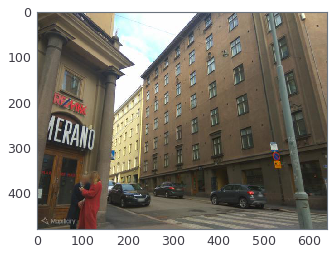

In [96]:
from PIL import Image
f =  '/datasets_1/sagarj/BellLabs/CitySV_Data/CITY_MAPPILARY_IMAGES/' + max_images.iloc[14]['Imgkey'] +'.jpg'
print(f)
img = Image.open(f)
plt.grid(False)
plt.imshow(img)

In [64]:
total_mappilary_df[['Architecture','Landmark','Walkable','Natural']]

,Architecture,Landmark,Walkable,Natural
0,0.4,0.0,0.4,0.0
1,0.4,0.0,0.4,0.0
2,0.4,0.0,0.4,0.0
3,0.0,0.2,0.4,0.0
4,0.4,0.0,0.4,0.0
...,...,...,...,...
798239,0.4,0.0,0.4,0.0
798240,0.0,0.2,0.6,0.0
798241,0.2,0.0,0.6,0.0
798242,0.2,0.0,0.6,0.0


In [45]:
sums = total_mappilary_df[['Architecture','Landmark','Walkable','Natural']].sum(axis=0)

In [ ]:
sums

In [199]:
from tqdm import tqdm
# city_dict = {'city': [] , 'objectEntropy_mean': [], 'SegnetEntropy_mean': [] , 'Car_Infrastructure_enet' : [] , 'Pedestrians_enet' : [] , 'Architecture_enet': [] , 'Nature_enet' : [],
#             'Car_Infrastructure_coco' : [] , 'Pedestrians_coco': [] , 'Walkability' : [] , 'Landmark':[], 'Architecture': [], 'Natural': [],
#             'Place_entropy':[]}
city_dict = {'city': [] , 'Car_Infrastructure_enet' : [] , 'Pedestrians_enet' : [] , 'Architecture_enet': [] , 'Nature_enet' : [],
             'Walkability' : [] , 'Landmark':[], 'Architecture': [], 'Natural': [], 'Place_entropy':[],'Place_entropy_w_o_natural':[] , 'scene_dist':[]}


for name , group in tqdm(total_mappilary_df.groupby('city')):
    city_dict['city'].append(name)
#     city_dict['objectEntropy_mean'].append(np.mean(group['coco_entropy_new']))
#     city_dict['SegnetEntropy_mean'].append(np.mean(group['segNet_entropy_new']))
    city_dict['Car_Infrastructure_enet'].append(np.mean(group['Car_Infrastructure_enet']))
    city_dict['Pedestrians_enet'].append(np.mean(group['Pedestrians_enet']))
    city_dict['Architecture_enet'].append(np.mean(group['Architecture_enet']))
    city_dict['Nature_enet'].append(np.mean(group['Nature_enet']))
#     city_dict['Car_Infrastructure_coco'].append(np.sum(group['Car_Infrastructure_coco']))
#     city_dict['Pedestrians_coco'].append(np.sum(group['Pedestrians_coco']))
#     city_dict['Architecture_coco'].append(np.sum(group['Architecture_coco']))
#     city_dict['Nature_coco'].append(np.sum(group['Nature_coco']))
    scene_dist = group[['Architecture','Landmark','Walkable','Natural']].sum(axis=0)
    city_dict['scene_dist'].append(scene_dist)
    city_dict['Place_entropy_w_o_natural'].append(Entropy([scene_dist[k] for k in ['Architecture','Landmark','Walkable']]))
    city_dict['Place_entropy'].append(Entropy([scene_dist[k] for k in ['Architecture','Landmark','Natural','Walkable']]))
    total_images = len(group)
    print(name , total_images)

    city_dict['Natural'].append(scene_dist['Natural']/sum(scene_dist.values))
    city_dict['Architecture'].append(scene_dist['Architecture']/sum(scene_dist.values))
    city_dict['Landmark'].append(scene_dist['Landmark']/sum(scene_dist.values))
    city_dict['Walkability'].append(scene_dist['Walkable']/sum(scene_dist.values))

#     city_dict['Natural'].append(np.log(total_images/scene_dist['Natural']))
#     city_dict['Architecture'].append(np.log(total_images/scene_dist['Architecture']))
#     city_dict['Landmark'].append(np.log(total_images/scene_dist['Landmark']))
#     city_dict['Walkability'].append(np.log(total_images/scene_dist['Walkable']))
    
#     city_dict['Natural'].append((np.log(total_images/len(group[group['Natural'] >= 0.6])))*np.log(1+scene_dist['Natural']))
#     city_dict['Architecture'].append(np.log(total_images/len(group[group['Architecture'] >= 0.6]))*np.log(1+scene_dist['Architecture']))
#     city_dict['Landmark'].append(np.log(total_images/len(group[group['Landmark'] >= 0.6]))*np.log(1+scene_dist['Landmark']))
#     city_dict['Walkability'].append(np.log(total_images/len(group[group['Walkable'] >= 0.6]))*np.log(1+scene_dist['Walkable']))

#     city_dict['Natural'].append((np.log(sum(scene_dist.values)/scene_dist['Natural']))*np.log(1+scene_dist['Natural']))
#     city_dict['Architecture'].append((np.log(sum(scene_dist.values)/scene_dist['Architecture']))*np.log(1+scene_dist['Architecture']))
#     city_dict['Landmark'].append((np.log(sum(scene_dist.values)/scene_dist['Landmark']))*np.log(1+scene_dist['Landmark']))
#     city_dict['Walkability'].append((np.log(sum(scene_dist.values)/scene_dist['Walkable']))*np.log(1+scene_dist['Walkable']))

city_mappilary_df = pd.DataFrame.from_dict(city_dict)

100%|██████████| 21/21 [00:00<00:00, 43.08it/s]

Berlin 56582
Chicago 10913
Dusseldorf 5603
Frankfurt 27664
Hamburg 78714
Helsinki 109542
Houston 20037
London 16617
Los Angeles 4742
Madrid 20094
Manhattan 18258
Moscow 125295
Munich 26373
New York 6326
Paris 32607
San Francisco 45135
Stockholms kommun 28378
Tokyo 65706
Toronto 2470
Vienna 70433
Zurich 26755


In [200]:
dist = {'Architecture' :0 , 'Landmark':0 , 'Walkable' :0, 'Natural' :0}
for i in range(len(city_mappilary_df)):
    for k in dist:
        dist[k]+=city_mappilary_df['scene_dist'].iloc[i][k]
print(dist)


{'Architecture': 240734.40000008367, 'Landmark': 146794.80000004006, 'Walkable': 275673.6000000395, 'Natural': 42378.799999998846}


/work/sagarj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  


(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.]),
 <a list of 7 Text yticklabel objects>)

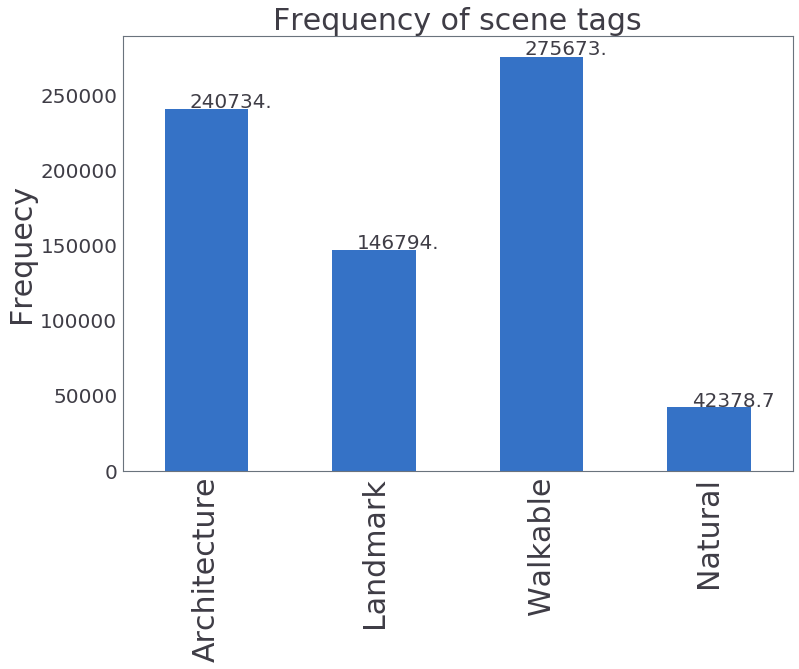

In [201]:
Y = [dist[k] for k in dist]
R2_series = pd.Series.from_array(Y)
X_labels = [k for k in dist]
# Plot the figure.
plt.figure(figsize=(12, 8))
ax = R2_series.plot(kind='bar')
plt.grid(False)
for p in ax.patches:
    ax.annotate(str(p.get_height())[:7], (p.get_x() + 0.15 , p.get_height() * 1.005),fontsize = 20)
# plt.ylim(0.0, 1.0)
# ax.set_title('$R^2$ for crime per capita models',fontsize=30)
ax.set_title('Frequency of scene tags',fontsize=30)
ax.set_ylabel('Frequecy',fontsize=30)
ax.set_xticklabels(X_labels,fontsize=30)
plt.yticks(fontsize=20)


In [202]:
# sns.distplot(total_mappilary_df['Natural'])

In [203]:
# sns.distplot(total_mappilary_df['Architecture'])

In [204]:
# sns.distplot(total_mappilary_df['Architecture'])

In [205]:
city_mappilary_df.head(n=4)

,city,Car_Infrastructure_enet,Pedestrians_enet,Architecture_enet,Nature_enet,Walkability,Landmark,Architecture,Natural,Place_entropy,Place_entropy_w_o_natural,scene_dist
0,Berlin,0.423378,0.096035,0.219201,0.244559,0.331003,0.156391,0.456516,0.056090,1.175682,1.016638,Architecture 23883.2 Landmark 8181....
1,Chicago,0.302553,0.088358,0.152131,0.435303,0.227603,0.195608,0.488483,0.088306,1.220316,1.011014,Architecture 5178.8 Landmark 2073.8 ...
2,Dusseldorf,0.319405,0.091264,0.284240,0.287618,0.331392,0.211874,0.380403,0.076331,1.258778,1.070837,Architecture 1946.6 Landmark 1084.2 ...
3,Frankfurt,0.306747,0.124709,0.316827,0.197020,0.279937,0.245090,0.398448,0.076525,1.264354,1.076545,Architecture 9579.4 Landmark 5892.4 ...


In [206]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
data = city_mappilary_df.copy()

min_walk = min(data['Walkability']) 
max_walk = max(data['Walkability'])

min_land = min(data['Landmark'])
max_land = max(data['Landmark'])

min_arch = min(data['Architecture'])
max_arch = max(data['Architecture'])

min_nat = min(data['Natural'])
max_nat = max(data['Natural'])

min_transport = min(data['Car_Infrastructure_enet']) 
max_transport = max(data['Car_Infrastructure_enet'])

min_walkable = min(data['Pedestrians_enet'])
max_walkable = max(data['Pedestrians_enet'])

min_built = min(data['Architecture_enet'])
max_built = max(data['Architecture_enet'])

min_natural = min(data['Nature_enet'])
max_natural = max(data['Nature_enet'])


# data['Walkability'] = data['Walkability'].apply(lambda x:((x - min_walk)/(max_walk-min_walk))*100.0)
# data['Landmark'] = data['Landmark'].apply(lambda x:((x - min_land)/(max_land-min_land))*100.0)
# data['Architecture'] = data['Architecture'].apply(lambda x:((x - min_arch)/(max_arch-min_arch))*100.0)
# data['Natural'] = data['Natural'].apply(lambda x:((x - min_nat)/(max_nat-min_nat))*100.0)

data['Walkability'] = data['Walkability'].apply(lambda x:((x - min_walk)/(max_walk-min_walk))*100.0)
data['Landmark'] = data['Landmark'].apply(lambda x:((x - min_land)/(max_land-min_land))*100.0)
data['Architecture'] = data['Architecture'].apply(lambda x:((x - min_arch)/(max_arch-min_arch))*100.0)
data['Natural'] = data['Natural'].apply(lambda x:((x - min_nat)/(max_nat-min_nat))*100.0)

# data ['Transport'] = data['Car_Infrastructure_enet'].apply(lambda x : ((x - min_transport) / (max_transport - min_transport))*100.0)
# data['Walkable'] = data['Pedestrians_enet'].apply(lambda x : ((x - min_walkable) / (max_walkable - min_walkable))*100.0)
# data['Built'] = data['Architecture_enet'].apply(lambda x : ((x - min_built) / (max_built - min_built))*100.0)
# data['Natural'] = data['Nature_enet'].apply(lambda x : ((x - min_natural) / (max_natural - min_natural))*100.0)

# metrics = ['Transport' , 'Walkable' , 'Built' , 'Natural' ]
metrics = ['Landmark' , 'Walkability' , 'Architecture'  ]
data_copy = {'city' : [] , 'metric' : [] , 'value' : [] , 'pop' : []}
for index , row in data.iterrows():
    for metric in metrics:
        data_copy['city'].append(row['city'])
        data_copy['metric'].append(metric)
        data_copy['value'].append(row[metric])
        data_copy['pop'].append(1000000)
data_plot_df = pd.DataFrame.from_dict(data_copy)

In [207]:
data

,city,Car_Infrastructure_enet,Pedestrians_enet,Architecture_enet,Nature_enet,Walkability,Landmark,Architecture,Natural,Place_entropy,Place_entropy_w_o_natural,scene_dist
0,Berlin,0.423378,0.096035,0.219201,0.244559,51.119699,2.488411,85.576721,12.248896,1.175682,1.016638,Architecture 23883.2 Landmark 8181....
1,Chicago,0.302553,0.088358,0.152131,0.435303,26.379652,33.771046,98.687606,22.512974,1.220316,1.011014,Architecture 5178.8 Landmark 2073.8 ...
2,Dusseldorf,0.319405,0.091264,0.284240,0.287618,51.212901,46.745640,54.359638,18.697739,1.258778,1.070837,Architecture 1946.6 Landmark 1084.2 ...
3,Frankfurt,0.306747,0.124709,0.316827,0.197020,38.901536,73.241514,61.760375,18.759626,1.264354,1.076545,Architecture 9579.4 Landmark 5892.4 ...
4,Hamburg,0.417139,0.118985,0.236723,0.183411,85.777541,15.901156,26.344011,6.754577,1.146659,1.022109,Architecture 21529.2 Landmark 11948....
5,Helsinki,0.335996,0.144628,0.257337,0.096660,66.911741,37.510258,44.826572,8.887573,1.197223,1.060346,Architecture 34569.8 Landmark 19386....
6,Houston,0.421484,0.064195,0.266656,0.222102,0.000000,100.000000,14.375762,96.681243,1.329452,1.033690,Architecture 5195.4 Landmark 5116.8 ...
7,London,0.404137,0.131916,0.240396,0.169135,71.847565,40.724228,32.260685,10.792738,1.207378,1.058981,Architecture 4659.6 Landmark 2915.8 ...
8,Los Angeles,0.304894,0.102096,0.214451,0.370784,0.614127,30.611712,44.727916,100.000000,1.304629,1.001439,Architecture 1688.8 Landmark 906.8 ...
9,Madrid,0.277816,0.102116,0.376015,0.169309,59.596413,28.112695,64.509526,7.092089,1.177012,1.051333,Architecture 7186.4 Landmark 3343.8 ...


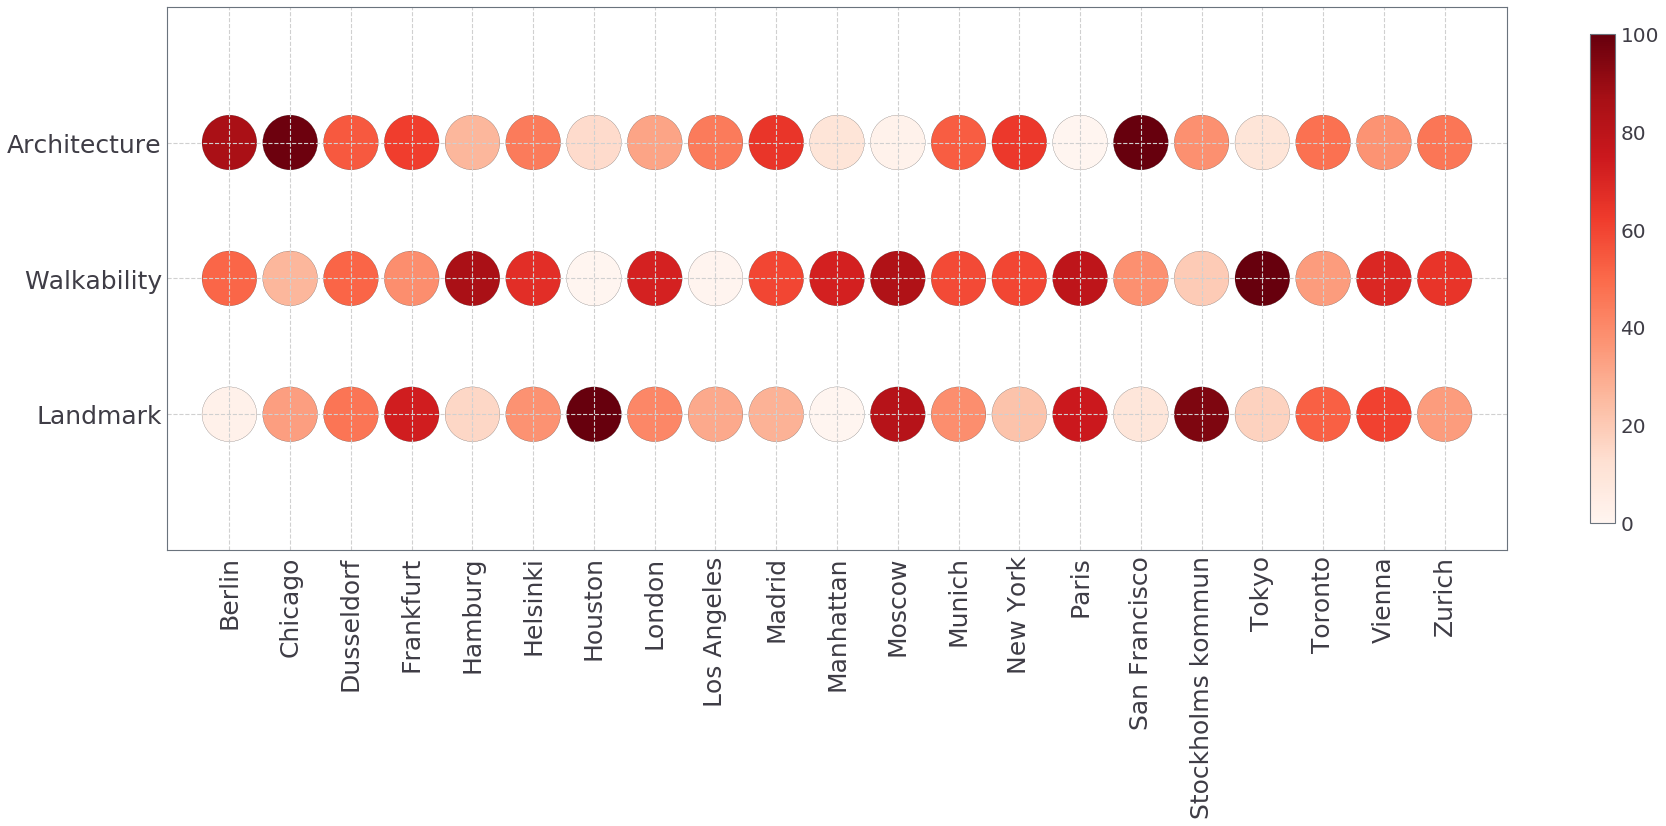

In [208]:
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle

#figure preparation with grid and scaling
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_ylim(-1,3,1)
ax.grid(ls="--")

X = "metric"
Y = "city"
H = "value"
s = "pop"
#upscale factor for scatter marker size
scale=3000/max(data_plot_df['pop'])

sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=data_plot_df['value'].min(), vmax=data_plot_df['value'].max()))
plt.xticks(fontsize=25,rotation = 90)
plt.yticks(fontsize=25)
ax.scatter(data_plot_df[Y], 
           data_plot_df[X], 
           s=data_plot_df[s]*scale, 
           c= data_plot_df[H] , edgecolor="black", marker=MarkerStyle("o"), 
           cmap = 'Reds')
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.9)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
# ticklabs = cbar.ax.get_yticklabels()
# cbar.ax.set_yticklabels(ticklabs, fontsize=10)


In [209]:
city_mappilary_df = pd.merge(city_mappilary_df,city_road_entropy,left_on='city' , right_on='city')

In [210]:
city_mappilary_df

,city,Car_Infrastructure_enet,Pedestrians_enet,Architecture_enet,Nature_enet,Walkability,Landmark,Architecture,Natural,Place_entropy,Place_entropy_w_o_natural,scene_dist,street_entropy
0,Berlin,0.423378,0.096035,0.219201,0.244559,0.331003,0.156391,0.456516,0.056090,1.175682,1.016638,Architecture 23883.2 Landmark 8181....,3.430909
1,Chicago,0.302553,0.088358,0.152131,0.435303,0.227603,0.195608,0.488483,0.088306,1.220316,1.011014,Architecture 5178.8 Landmark 2073.8 ...,2.671477
2,Dusseldorf,0.319405,0.091264,0.284240,0.287618,0.331392,0.211874,0.380403,0.076331,1.258778,1.070837,Architecture 1946.6 Landmark 1084.2 ...,3.506124
3,Frankfurt,0.306747,0.124709,0.316827,0.197020,0.279937,0.245090,0.398448,0.076525,1.264354,1.076545,Architecture 9579.4 Landmark 5892.4 ...,3.440617
4,Hamburg,0.417139,0.118985,0.236723,0.183411,0.475853,0.173206,0.312096,0.038845,1.146659,1.022109,Architecture 21529.2 Landmark 11948....,2.207576
5,Helsinki,0.335996,0.144628,0.257337,0.096660,0.397005,0.200296,0.357160,0.045539,1.197223,1.060346,Architecture 34569.8 Landmark 19386....,3.570721
6,Houston,0.421484,0.064195,0.266656,0.222102,0.117350,0.278635,0.282915,0.321099,1.329452,1.033690,Architecture 5195.4 Landmark 5116.8 ...,2.864279
7,London,0.404137,0.131916,0.240396,0.169135,0.417634,0.204325,0.326522,0.051519,1.207378,1.058981,Architecture 4659.6 Landmark 2915.8 ...,3.559425
8,Los Angeles,0.304894,0.102096,0.214451,0.370784,0.119917,0.191648,0.356919,0.331516,1.304629,1.001439,Architecture 1688.8 Landmark 906.8 ...,3.477084
9,Madrid,0.277816,0.102116,0.376015,0.169309,0.366431,0.188515,0.405151,0.039904,1.177012,1.051333,Architecture 7186.4 Landmark 3343.8 ...,3.502409


In [211]:
city_mappilary_df.corr()

,Car_Infrastructure_enet,Pedestrians_enet,Architecture_enet,Nature_enet,Walkability,Landmark,Architecture,Natural,Place_entropy,Place_entropy_w_o_natural,street_entropy
Car_Infrastructure_enet,1.000000,-0.125050,-0.415167,-0.343454,0.377188,-0.030667,-0.379877,-0.163548,-0.265586,-0.066656,-0.348504
Pedestrians_enet,-0.125050,1.000000,0.116560,-0.512768,0.437337,-0.217781,-0.052418,-0.420863,-0.331349,0.030744,0.268918
Architecture_enet,-0.415167,0.116560,1.000000,-0.483714,0.136180,0.310543,-0.189271,-0.148979,-0.148110,0.289233,0.515435
Nature_enet,-0.343454,-0.512768,-0.483714,1.000000,-0.643261,-0.141204,0.445428,0.517037,0.491086,-0.270058,-0.324477
Walkability,0.377188,0.437337,0.136180,-0.643261,1.000000,-0.316760,-0.401375,-0.814527,-0.760716,0.041684,0.017787
Landmark,-0.030667,-0.217781,0.310543,-0.141204,-0.316760,1.000000,-0.391370,0.299811,0.414322,0.585678,0.230542
Architecture,-0.379877,-0.052418,-0.189271,0.445428,-0.401375,-0.391370,1.000000,-0.122257,0.008179,-0.132617,-0.067566
Natural,-0.163548,-0.420863,-0.148979,0.517037,-0.814527,0.299811,-0.122257,1.000000,0.782932,-0.186592,-0.063092
Place_entropy,-0.265586,-0.331349,-0.148110,0.491086,-0.760716,0.414322,0.008179,0.782932,1.000000,0.315419,-0.029874
Place_entropy_w_o_natural,-0.066656,0.030744,0.289233,-0.270058,0.041684,0.585678,-0.132617,-0.186592,0.315419,1.000000,0.250802


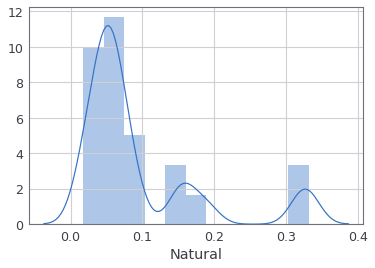

In [212]:
sns.distplot(city_mappilary_df['Natural'])

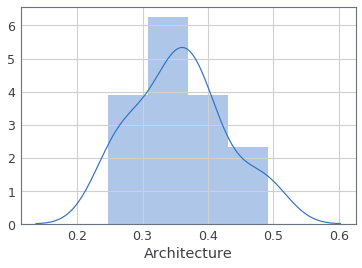

In [213]:
sns.distplot(city_mappilary_df['Architecture'])

In [214]:
city_mappilary_df.columns

Index(['city', 'Car_Infrastructure_enet', 'Pedestrians_enet',
       'Architecture_enet', 'Nature_enet', 'Walkability', 'Landmark',
       'Architecture', 'Natural', 'Place_entropy', 'Place_entropy_w_o_natural',
       'scene_dist', 'street_entropy'],
      dtype='object')

[Text(0, 0.5, 'Walkability'),
 Text(0, 1.5, 'Landmark'),
 Text(0, 2.5, 'Natural'),
 Text(0, 3.5, 'Architecture'),
 Text(0, 4.5, 'street_entropy'),
 Text(0, 5.5, 'Car_Infrastructure_enet'),
 Text(0, 6.5, 'Nature_enet'),
 Text(0, 7.5, 'Pedestrians_enet'),
 Text(0, 8.5, 'Architecture_enet')]

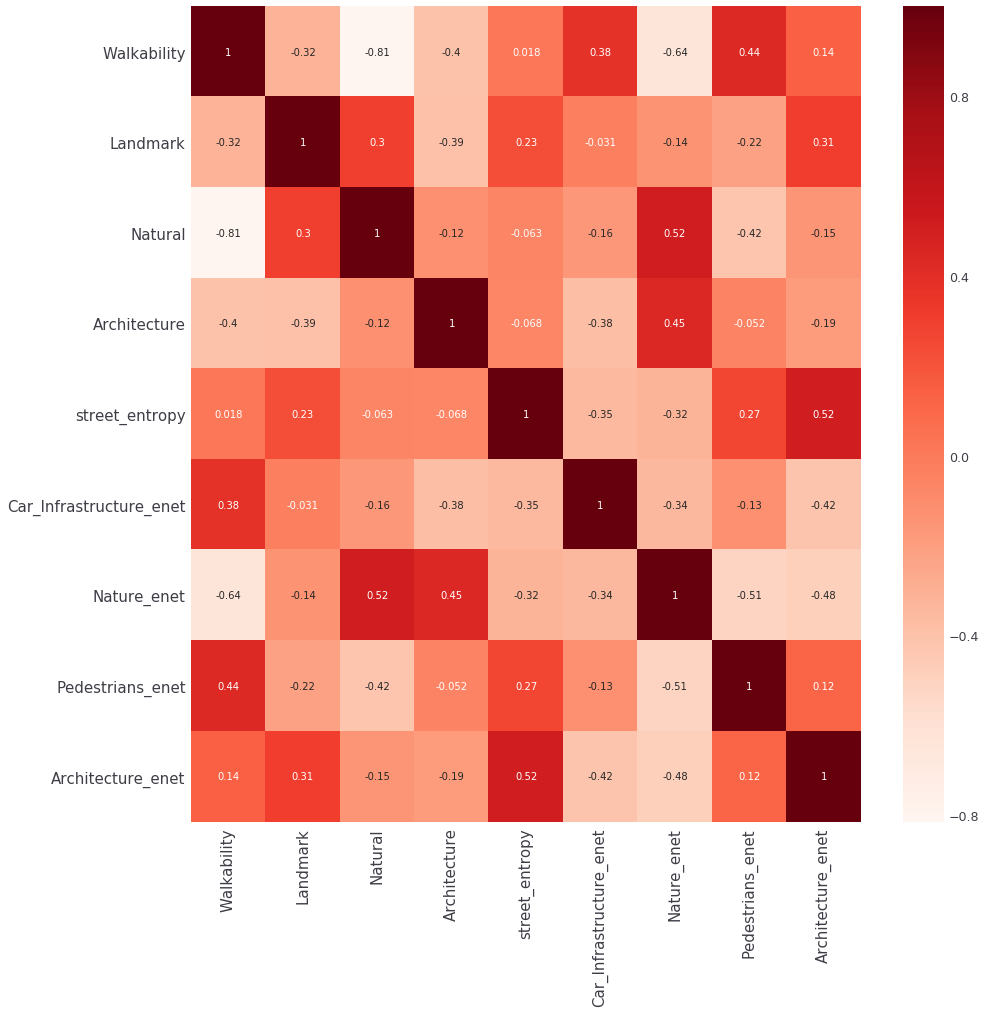

In [215]:
feats = ['city','Walkability', 'Landmark', 'Natural', 'Architecture', 'street_entropy','Car_Infrastructure_enet','Nature_enet','Pedestrians_enet','Architecture_enet']
fig, ax = plt.subplots(figsize=(15,15))         
corr = city_mappilary_df[feats].corr(method='pearson')
sns.heatmap(corr, annot=True , ax=ax ,cmap='Reds' )
ax.set_xticklabels(corr.columns, fontsize=15)
ax.set_yticklabels(corr.columns, fontsize=15,rotation=0)

In [216]:
sub_file = city_mappilary_df[feats].copy()

In [218]:
sub_file.to_csv('scratchpad/city_mappilary_features_v5.csv')

In [133]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [134]:
pvals = calculate_pvalues(city_mappilary_df[feats])


In [135]:
pvals

,Walkability,Landmark,Natural,Architecture,street_entropy,Car_Infrastructure_enet,Nature_enet,Pedestrians_enet,Architecture_enet
Walkability,0,0.0097,0.0005,0.8258,0.7737,0.2187,0.0697,0.095,0.8091
Landmark,0.0097,0,0.0002,0.0371,0.7884,0.1803,0.0222,0.0703,0.6754
Natural,0.0005,0.0002,0,0.0273,0.3177,0.3019,0.0003,0.0466,0.1599
Architecture,0.8258,0.0371,0.0273,0,0.3653,0.0818,0.0055,0.6611,0.2254
street_entropy,0.7737,0.7884,0.3177,0.3653,0,0.1216,0.1513,0.2385,0.0168
Car_Infrastructure_enet,0.2187,0.1803,0.3019,0.0818,0.1216,0,0.1274,0.5891,0.0613
Nature_enet,0.0697,0.0222,0.0003,0.0055,0.1513,0.1274,0,0.0175,0.0263
Pedestrians_enet,0.095,0.0703,0.0466,0.6611,0.2385,0.5891,0.0175,0,0.6149
Architecture_enet,0.8091,0.6754,0.1599,0.2254,0.0168,0.0613,0.0263,0.6149,0
